**PLEASE UPVOTE IF FOUND INTERESTING**

Kernal for Preprocessing INKML to PNG Image to available [here](https://www.kaggle.com/kalikichandu/preprossing-inkml-to-png-files)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['handwrittenmathsymbols', 'handwritten-math-symbols-dataset']


In [2]:
print(os.listdir("../input/handwritten-math-symbols-dataset/handwrittenmathsymbols/data/extracted_images"))

['N', '7', 'theta', '!', 'pm', 'mu', 'R', '2', 'b', 'i', 'exists', 'f', 'log', 'tan', 'H', 'ascii_124', '5', 'e', 'leq', 'sqrt', 'forward_slash', '+', 'u', 'div', 'beta', 'M', '8', '[', 'gamma', 'int', 'X', '0', 'rightarrow', 'k', 'q', 'alpha', 'prime', 'y', 'S', 'phi', 'neq', 'G', 'cos', ')', 'times', 'A', 'sigma', 'gt', 'o', 'T', 'v', 'z', '3', '(', 'ldots', ',', '1', 'C', '}', 'sin', '4', 'pi', 'p', 'geq', '9', 'lambda', '{', 'in', 'l', '6', '=', 'w', 'd', '-', 'sum', 'Delta', 'infty', 'lim', 'j', ']', 'forall', 'lt']


Note - Here I have uploded the Zip Version of DataSet as private Dataset

In [3]:
!pip install split-folders    # Library to split Train and valid Image sets in ImageNet style

In [4]:
import os
import numpy as np
from tqdm import tqdm
from fastai import *
import torch
from fastai.vision import *
%matplotlib inline
from fastai.callbacks import *
import cv2
import pandas as pd
import splitfolders

In [5]:
image_load_size = 64
bs = 24

In [6]:
 def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True    

SEED = 999
seed_everything(SEED)

In [7]:
splitfolders.ratio('../input/handwritten-math-symbols-dataset/handwrittenmathsymbols/data/extracted_images', output="../final_output_images", seed=SEED, ratio=(.8, .2)) # default va

Copying files: 252614 files [17:31, 411.21 files/s]

In [8]:
tfms = get_transforms(do_flip=True, flip_vert=False, max_lighting=0.1, max_zoom=1.05,
                      max_warp=0.,
                      xtra_tfms=[rand_crop(), rand_zoom(1, 1.5),
                                 symmetric_warp(magnitude=(-0.2, 0.2))])

In [9]:
data = (ImageList.from_folder(path='../final_output_images')
        .split_by_folder(train='train',valid='val')
        .label_from_folder()
        .transform(tfms,size = image_load_size,resize_method=ResizeMethod.SQUISH)
        .databunch(path='.',bs=bs)    
        .normalize(imagenet_stats)
)

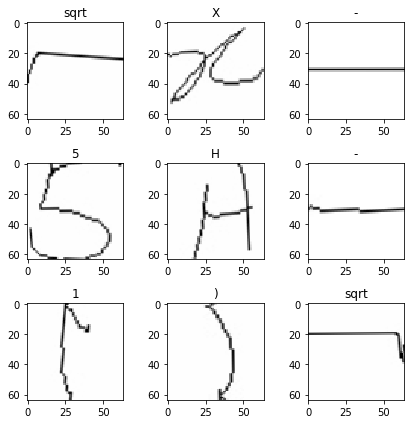

In [10]:
 data.show_batch(3, figsize=(6,6), hide_axis=False)

In [11]:
len(data.classes)

82

In [12]:
 data.classes

['!',
 '(',
 ')',
 '+',
 ',',
 '-',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '=',
 'A',
 'C',
 'Delta',
 'G',
 'H',
 'M',
 'N',
 'R',
 'S',
 'T',
 'X',
 '[',
 ']',
 'alpha',
 'ascii_124',
 'b',
 'beta',
 'cos',
 'd',
 'div',
 'e',
 'exists',
 'f',
 'forall',
 'forward_slash',
 'gamma',
 'geq',
 'gt',
 'i',
 'in',
 'infty',
 'int',
 'j',
 'k',
 'l',
 'lambda',
 'ldots',
 'leq',
 'lim',
 'log',
 'lt',
 'mu',
 'neq',
 'o',
 'p',
 'phi',
 'pi',
 'pm',
 'prime',
 'q',
 'rightarrow',
 'sigma',
 'sin',
 'sqrt',
 'sum',
 'tan',
 'theta',
 'times',
 'u',
 'v',
 'w',
 'y',
 'z',
 '{',
 '}']

In [13]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

In [14]:
model = cnn_learner(data,models.densenet161, metrics = [accuracy,error_rate],callback_fns=[partial(SaveModelCallback, monitor='accuracy', name='best_model')])
model.loss_func = FocalLoss()
model.summary()

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:03<00:00, 29.3MB/s]


Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [96, 32, 32]         14,112     False     
______________________________________________________________________
BatchNorm2d          [96, 32, 32]         192        True      
______________________________________________________________________
ReLU                 [96, 32, 32]         0          False     
______________________________________________________________________
MaxPool2d            [96, 16, 16]         0          False     
______________________________________________________________________
BatchNorm2d          [96, 16, 16]         192        True      
______________________________________________________________________
ReLU                 [96, 16, 16]         0          False     
______________________________________________________________________
Conv2d               [192, 16, 16]        18,432     False     
___________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-03
Min loss divided by 10: 3.98E-03


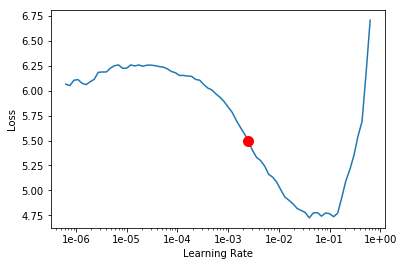

In [15]:
model.lr_find()
model.recorder.plot(suggestion = True)

In [16]:
lr = 2e-3
model.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-06
Min loss divided by 10: 6.31E-08


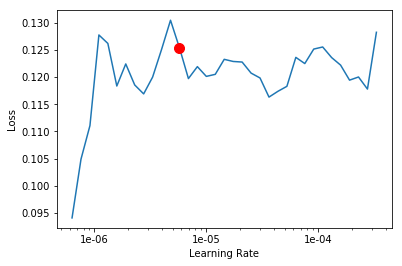

In [17]:
model.unfreeze()
model.lr_find()
model.recorder.plot(suggestion = True)

In [18]:
 model.fit_one_cycle(5,slice(1e-6,lr/10))

epoch,train_loss,valid_loss,accuracy,error_rate,time


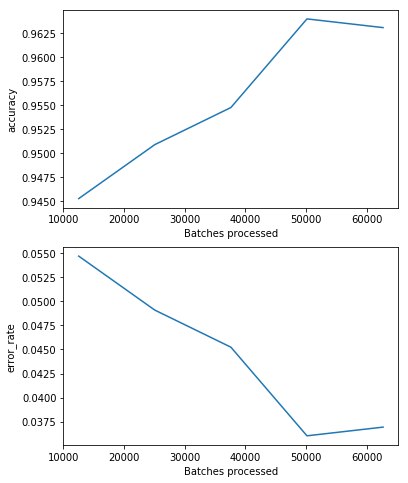

In [19]:
model.recorder.plot_metrics()

In [20]:
model.load('best_model')

Learner(data=ImageDataBunch;

Train: LabelList (300746 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
lim,lim,lim,lim,lim
Path: ../final_output_images;

Valid: LabelList (75228 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
lim,lim,lim,lim,lim
Path: ../final_output_images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1)

In [21]:
valid_loss_save_model,accuracy_save_model, error_rate_save_model = model.validate(model.data.valid_dl)
print('valid_loss:', valid_loss_save_model, 'accuracy:', float(accuracy_save_model),'error_rate:',float(error_rate_save_model))

valid_loss: 0.049449604 accuracy: 0.9639762043952942 error_rate: 0.0360238216817379


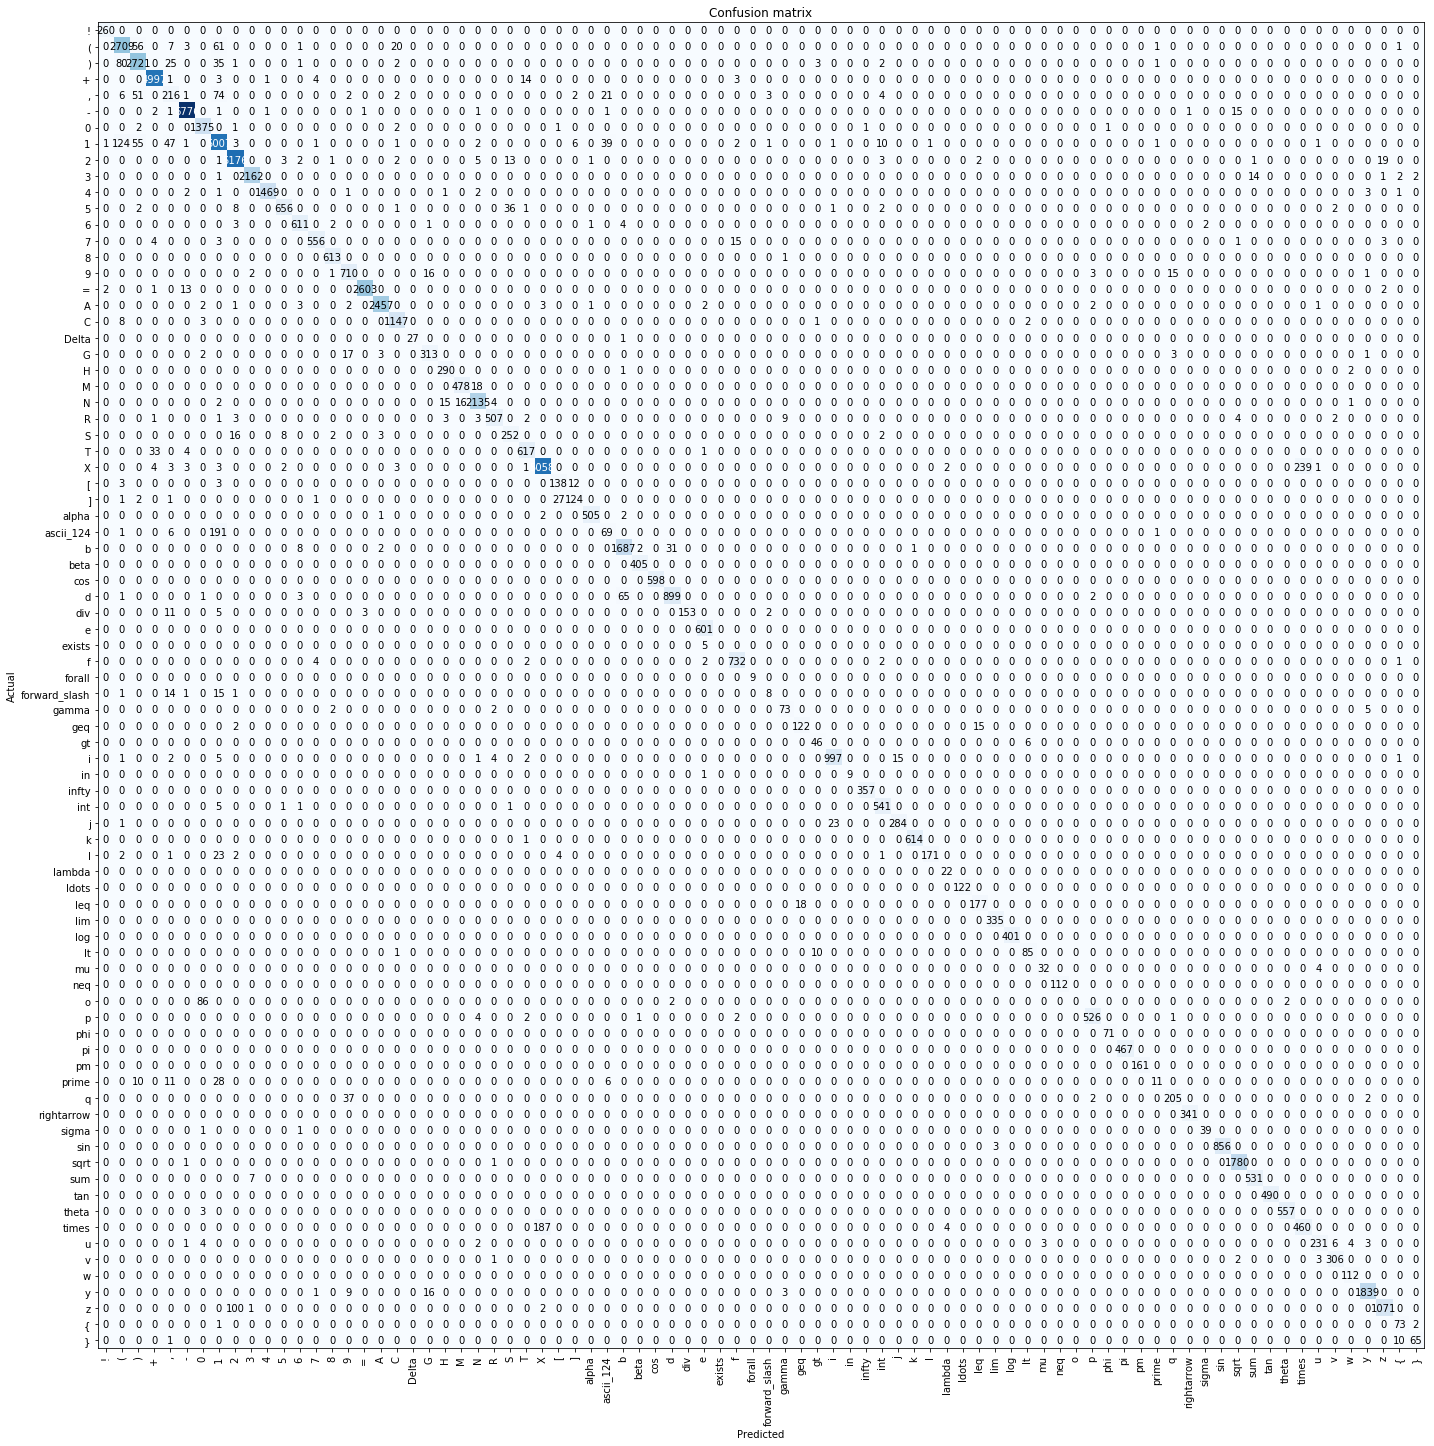

In [22]:
interpreter = ClassificationInterpretation.from_learner(model)
interpreter.plot_confusion_matrix(figsize = (20,20))

In [23]:
interpreter.most_confused(min_val=50)

[('X', 'times', 239),
 ('ascii_124', '1', 191),
 ('times', 'X', 187),
 ('1', '(', 124),
 ('z', '2', 100),
 ('o', '0', 86),
 (')', '(', 80),
 (',', '1', 74),
 ('d', 'b', 65),
 ('(', '1', 61),
 ('(', ')', 56),
 ('1', ')', 55),
 (',', ')', 51)]

In [24]:
print(os.listdir('../final_output_images/val/A'))

['exp3159.jpg', 'exp28170.jpg', 'a_33772.jpg', 'a_42568.jpg', 'exp10592.jpg', 'a_102228.jpg', 'exp26767.jpg', 'a_2748.jpg', 'exp37320.jpg', 'exp42270.jpg', 'a_1314.jpg', 'exp14976.jpg', 'exp35579.jpg', 'exp31974.jpg', 'exp40960.jpg', 'exp25941.jpg', 'exp37941.jpg', 'a_33674.jpg', 'a_58677.jpg', 'exp25750.jpg', 'A_70500.jpg', 'exp92892.jpg', 'exp7494.jpg', 'exp57291.jpg', 'exp99459.jpg', 'exp40853.jpg', 'exp56569.jpg', 'exp156.jpg', 'a_91710.jpg', 'exp3931.jpg', 'exp36074.jpg', 'exp16953.jpg', 'exp37947.jpg', 'exp34223.jpg', 'exp60269.jpg', 'exp43411.jpg', 'exp81629.jpg', 'exp2543.jpg', 'A_84761.jpg', 'exp50672.jpg', 'exp35198.jpg', 'A_34989.jpg', 'exp38299.jpg', 'A_70396.jpg', 'exp36142.jpg', 'exp87499.jpg', 'exp7908.jpg', 'exp65713.jpg', 'exp65400.jpg', 'exp87757.jpg', 'a_94068.jpg', 'exp42352.jpg', 'exp93065.jpg', 'a_102807.jpg', 'exp20684.jpg', 'a_30414.jpg', 'exp37474.jpg', 'exp59509.jpg', 'a_37206.jpg', 'exp38549.jpg', 'exp87446.jpg', 'a_34226.jpg', 'exp102180.jpg', 'exp29609.jpg'

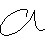

In [25]:
open_image('../final_output_images/val/A/exp3159.jpg')

In [26]:
pred = model.predict(open_image('../final_output_images/val/A/exp3159.jpg'))
print(pred[0])

A


Comment below incase if any clarification is needed.